In [1]:
from platform import python_version
print(python_version())


# In[3]:

#importing libraries
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel, Box2DKernel
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
# from reproject import reproject_exact  #a package that can be added to astropy using anaconda or pip (see their docs pg)
# from reproject import reproject_interp

import glob
import matplotlib 
matplotlib.use('Agg') #invokved b/c just plain matplotlib was insufficient
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys


#switches for the three different parts of this code
switch1 = 'on' #convolving images [needed to put it on for switch 3 at min...need to figure out other solution, eh]
switch1b = 'on' #regridding...
switch2 = 'on' #solving equations
switch3 = 'on' #plotting / graphics of solutions


if switch1 == 'on':

    # In[4]:

    # #finding the path to every fits images in a directory
    def im_name_finder(path, file_type):
        #Using glob (it's a unix command similar to ls)
        #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
        #if needed, some example code is commented towards the latter half of this code that could help make an alternative
        all_names = glob.glob(path, recursive=True)

        #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
        #using s.lower() include uppercase names
        im_names = [s for s in all_names if 'fit' in s.lower()]

        return im_names


    # In[5]:

    '''now convolve my image with a PSF of the image we're projecting ONTO
    an approx PSF can be found by assuming a 2D Gaussian func with a width (a FWHM) of the diffrac limit
    that is the st dev of the Gaussian is about the st dev is about = lambda/D
    a list of PSFs are found on https://docs.astropy.org/en/stable/convolution/kernels.html

    Notes:
    FIRST: always must convert hdu1_pixtorad to radians! It's inconsistent otherwise, and lambda/D is generally in radians

    what we're using for the gaussian width is the FWHM, not the radius of the first ring of the diffraction pattern,
    so it's 1.2 not 1.22 times lambda/D

    D is 85 cm for spitzer
    D is 2.4 m for hubble
    '''

    def im_conv(low_res_name, D, hdu_pix_torad, hdu_dat, kern):
        #unfortuantely no good way to find wavelength from header right now. can enter it manually, but I tried to automate it

        #reading in excel file of wavelengths...right now needs to be in same directory as this code
        #first col is a substring of the fits image file name, the second col is the wavelengths in microns
        df = pd.read_excel('../../../imglams.xlsx')
        cols = df.columns
        cols_str = [str(i) for i in df[cols[0]]]
        #some test cases I was using

        #gaussian kernel
        if kern == 'gauss':
            #this finds the loc in the excel file where the image substring matches our image name
            #it then finds the wavelength value corresponding to that loc
            lam =  df.loc[np.where([i in low_res_name for i in cols_str])[0][0]].values[1] #lambda in microns
            
            #finding angular resolution...the FWHM of our Gaussian PSF
            res = 1.2 * lam / D         #resolution in radians
#             print('Angular Res (rads): ', res, ' File Name to Convolve With: ', low_res_name, ' Lambda: ', lam)
            res = res / hdu_pix_torad        #so converting to pixels
#             print('Angular Res (pixels): ', res, ' File Name to Convolve With: ', low_res_name, ' Lambda: ', lam)

            #finding PSF and then calculating the convolution of our image and the PSF of the image we're projecting onto
            kernel = Gaussian2DKernel(res)
        
        #box kernel
        if kern == 'box':
            kernel = Box2DKernel(16.)

        hdu_conv = convolve(hdu_dat, kernel)
        return hdu_conv


    # In[21]:

    #EX: grabbing all the fits image paths in a directory, so they can be looped through and their data opened
    #set your path to some directory with images (the images can be in subdirectories)
    #using ** will grab all files even in subdirectories...WARNING this will take longer

    # In[28]:
    #this time setting up the file names by hand since I've found that easier...
    #order: halpha or .656 mic, 0.672 mic, 1.26, 1.28, 1.64
    files_units = ['../../../../ngc1333_fits/unregridded/656_image.fits', 
                   '../../../../ngc1333_fits/unregridded/0301_flt.fits', 
                   '../../../../ngc1333_fits/unregridded/0501_flt.fits', 
                   '../../../../ngc1333_fits/126build_shift_2_drz.fits', 
                   '../../../../ngc1333_fits/128build_shift_2_drz.fits', 
                   '../../../../ngc1333_fits/164build_shift_2_drz.fits']
    hdu_list_units = [fits.open(i) for i in files_units]
    files_data = ['../../../../ngc1333_fits/656_hareproject_shifted_up5_left3.fits', 
                  '../../../../ngc1333_fits/0301_oIreproject2.fits', 
                  '../../../../ngc1333_fits/672_sIIreproject.fits', 
                  '../../../../ngc1333_fits/Background_corr/background_corr_126_aligned.fits', 
                  '../../../../ngc1333_fits/Background_corr/background_corr_128_aligned.fits', 
                  '../../../../ngc1333_fits/Background_corr/background_corr_164_aligned.fits']
    hdu_list = [fits.open(i) for i in files_data]

    hdu_pix_list = []
    hdu_pixtorad_list = []
    hdu_fnu_list = []
    hdu_flam_list = []
    hdu_bw_list = []
    hdu_data_list = []
    hdu_header_list = []
    throughput_list = [1., 1., 1., 1., 1., 1.] # [0.242, 1., 0.246, 0.496, 0.521, 0.470] #also has to be done by hand, not in the headers?


    #I'm using count here just to point to specific indices that I've set up...unfortunately some have different headers...
    #the only diff between the if and else cases are the indexing of the hdu's, some need 1 and some need 0
    #I've tried to group it for convience, so the the first two have the same headers, the last 3 have the same headers
    count = 0
    for (hdu_units,hdu_data) in zip(hdu_list_units, hdu_list):
        if count <= 2: # == 0 or count == 2:
            #reading in conversions
            hdu_pix_list.append(hdu_units[0].header['D001SCAL'])  #D001SCAL is the keyword for Hubble images
            hdu_pixtorad_list.append(hdu_pix_list[count] / 206265.)
#             print('D001SCAL: ', hdu_pix_list[count], ' D001SCAL/206265: ', hdu_pixtorad_list[count])
            # hdu_fnu_list.append(hdu_units[1].header['PHOTFNU'])
            hdu_flam_list.append(hdu_units[1].header['PHOTFLAM'])
            hdu_bw_list.append(hdu_units[1].header['PHOTBW'])

            #reading in datafor general use  and header for wcs
            hdu_data_list.append(hdu_data[0].data)
            hdu_header_list.append(hdu_data[0].header)

        else:
            #reading in conversions
            hdu_pix_list.append(hdu_units[0].header['D001SCAL'])  #D001SCAL is the keyword for Hubble images
            hdu_pixtorad_list.append(hdu_pix_list[count] / 206265.)
#             print('D001SCAL: ', hdu_pix_list[count], ' D001SCAL/206265: ', hdu_pixtorad_list[count])
            # hdu_fnu_list.append(hdu_units[0].header['PHOTFNU'])
            hdu_flam_list.append(hdu_units[0].header['PHOTFLAM'])
            hdu_bw_list.append(hdu_units[0].header['PHOTBW'])

            #reading in datafor general use  and header for wcs
            hdu_data_list.append(hdu_data[0].data)
            hdu_header_list.append(hdu_data[0].header)

        count += 1


    #can update later...but basically the sulfur II image header isn't avail...
    #header info taken from https://www.stsci.edu/hst/instrumentation/wfc3/data-analysis/photometric-calibration/uvis-photometric-calibration/quad-filter-photometry
    #update: HAlpha etc uses https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2021/WFC3_ISR_2021-04.pdf
    hdu_flam_list[0] = 1.6600e-17
    hdu_bw_list[0] = 41.77 #from Dan, in A
    hdu_flam_list[2] = 1.3699e-17
    hdu_bw_list[2] = 18.5

    print('loaded data!')


    '''
    need to do mutual convolutions...it doesn't look like a loop would help much
    I really couldn't find a loop, so I just do this mostly by hand...
    the basic idea is to run all combinations of convolutions so each image is convolved with each other's psf

    here I'm using the function im_conv, which requires the data file name to find the wavelength, the D for the resolution to convolve to, the pixel conversion, and the data that we are convolving
    '''

    res_str = '656shifted_flam' #used to label what we're saving, usually related to units or whether we're doing a gaussian or box convolution, etc
    # resize = 60. #if trying to adjust size of gaussian convolution
    D = 2.4 #/ resize #that of Hubble, in m
    D *= 1e6 #converting to microns since x m / 1 m * 1E6 microns gets microns, the unit of our wavelength file

    #format: conv(data convolving with, Diameter, pix size convolving with, image data to be convolved, convolution method)
    #do each with its own psf
    hdu_conv_list = [im_conv(i, D, j, k, 'gauss') for i,j,k in zip(files_data, hdu_pixtorad_list, hdu_data_list)]

    hdu_conv_list = [im_conv('164_dash', D, j, k, 'gauss') for j,k in zip(hdu_pixtorad_list, hdu_conv_list)]


    print('convolved!')
        
    '''
    onto converting units and regridding...
    '''
    #converting the convolved image to correct units and saving it so we can reproject it
    #conversion needed for hubble case since units are not in terms of surface brightness
    hdu_conv_scaled_list = []

    #for each convolved image, we need to convert from e-/s to flambda units which are in erg/s/cm^2/Angstrom...multiply by bw to get rid of angstrom
    #...also images are divided through by throughput, so multiplying by throughput
    #and lastly dividing by the arcsec^2 to get the image in surface brightness units, to be used in regridding
    for count, i in enumerate(hdu_conv_list):

        #a condition added since the background corrected images have units corrected?
        if  count > 2: #the background subtracted images
            hdu_conv_scaled_list.append(i) #/ hdu_pixtorad_list[count]**2. ) #note if doing regridding should also add in , regrid only takes surface brightness
        elif count <= 2:
        	hdu_conv_scaled_list.append(i * hdu_flam_list[count] * hdu_bw_list[count])


# In[6]:
#need a wcs standard for regridding and plots, fits files...
w = WCS(hdu_header_list[-1]) #I picked 0 arbitrarily, it shouldn't really matter
# wcs_header = w.to_header()
wcs_header = hdu_header_list[-1]
wcs_header['HISTORY'] = 'Image was convolved and regridded, units were converted only for 656, 672, and 631 images. Units are all flux in CGS (ergs/s/cm^2).'	#adding history keyword so we know what we did to this image


############################################################################################################################################################
#code part 2!
#############################################################################################################################################################

if switch2 == 'on':
    #continuum of filament fluxes
    #again, removing the 1th element here, which corresponds to 672, which we're ignoring for now...then again for OI
    del hdu_bw_list[1]
    del hdu_bw_list[1]
    bw_arr = np.array(hdu_bw_list) * 1e-8 #converting bandwidth from angstrom to cm, which is what we need for planck's law in cgs...


    #global vars for func
    h = 6.626e-27 #CGS units, ergs*sec
    c = 2.998e10 #CGS units, cm/s
    k_B = 1.38e-16 #CGS, ergs/K

    #list of wavelengths for each filter being used ... not sure how to code this automatically
    # lam_arr = 1e-6 * np.array([0.656, 1.26, 1.28, 1.64]) #in SI
    lam_arr = 1e-4 * np.array([0.656, 1.26, 1.28, 1.64]) #in CGS

    #func for planck's law, cgs, output is as a flux
    #https://yceo.yale.edu/sites/default/files/files/ComputingThePlanckFunction.pdf

    def B_lam(input_arr, temp=4500, const =1e-29):
        lam = input_arr
        return const * 2. * h * c**2. / lam**5. * 1. / (np.exp((h * c) / (lam*k_B*temp)) - 1.)



# In[7]:


if switch2 == 'on':

    #global vars for func
    R_Fe = 2.6 # 2.0 2.6, our default
    R_H = 33.9 # 32.5 # 25. 17.5 24.5, an alternate try that was abandoned
    y_arr = [0.47245, 0.77307, 0.78015, 0.85001]

        #for method curve_fit...func for non-linear equation...
    def scatt_func(lam_arr, C, A_V_fit, f_H, f_Fe):
        return np.array([
            (R_H * f_H + B_lam(lam_arr[0], T, C)) * y_arr[0]**A_V_fit, 
            (R_Fe * f_Fe + B_lam(lam_arr[1], T, C)) * y_arr[1]**A_V_fit,
            (f_H + B_lam(lam_arr[2], T, C)) * y_arr[2]**A_V_fit,
            (f_Fe + B_lam(lam_arr[3], T, C)) * y_arr[3]**A_V_fit ])


    print('set up functions for fitting!')

    #attempting many solvers
    from scipy.optimize import newton_krylov
    from scipy.optimize import curve_fit
    from scipy.optimize import least_squares


    #scaling by the signal to noise
    #from the regridded, convolved images...I collected the noise, though apparently it's not needed if we use background corrected images
    noise_656 = 4.4e-20 #* 0.242  # 0.302712 / 4.25e10 #multiplied these by throughputs
    noise_631 = 6e-20
    noise_672 = 8.70052e-20 #* 0.242  # 0.302712 / 4.25e10 #multiplied these by throughputs
    noise_126 = 2.6e-18 #* 0.496 #  0.216037 / 4.25e10 #times by throughput
    noise_128 = 2.75e-18 #* 0.521 # 0.258513 / 4.25e10 #times by throughput
    noise_164 = 5.766e-18  #* 0.470 # 0.39321 / 4.25e10 #times by throughput
    noise_list = [noise_656, noise_631, noise_672, noise_126, noise_128, noise_164]

    #looping through noise to invoke a singal to noise correction...can omit when using background corrected images
    data_corrected_list = []
    # perc = 1e0 #this tends to work?? Maybe can change...

    #if you are doing a singla ot noise cutoff
    # for data,noise in zip(hdu_conv_scaled_list, noise_list):   #OMITTED NOISE CORRECTION AS ATTEMPT, BUT WILL NEED IT EVENTUALLY.....
    #     data[data < -noise*perc] = np.nan
    #     data_corrected_list.append(data)

    #if you are doing a strict flux cutoff
    for data,noise in zip(hdu_conv_scaled_list, noise_list):   #OMITTED NOISE CORRECTION AS ATTEMPT, BUT WILL NEED IT EVENTUALLY.....
        data[data <= 0.1e-17] = np.nan
        data_corrected_list.append(data)

    flux_cutout = []
    
    #the entire large region coordinates
    cen_x = 550 #690
    cen_y = 460 #440
    del_x = 520 # 55
    del_y = 840 #100

    #trying to cut out the same region in all 4 images - speeds up processing...
    # #HH9? The arcy feature thing
    cutout1 = Cutout2D(data_corrected_list[0], (cen_x, cen_y), (del_y, del_x), wcs = w)
    flux_cutout.append(cutout1.data)

    cutout2 = Cutout2D(data_corrected_list[1], (cen_x, cen_y), (del_y, del_x), wcs = w)
    flux_cutout.append(cutout2.data)

    cutout3 = Cutout2D(data_corrected_list[2], (cen_x, cen_y), (del_y, del_x), wcs = w)
    flux_cutout.append(cutout3.data)

    cutout4 = Cutout2D(data_corrected_list[3], (cen_x, cen_y), (del_y, del_x), wcs = w)
    flux_cutout.append(cutout4.data)
    
    cutout5 = Cutout2D(data_corrected_list[4], (cen_x, cen_y), (del_y, del_x), wcs = w)
    flux_cutout.append(cutout5.data)

    cutout6 = Cutout2D(data_corrected_list[5], (cen_x, cen_y), (del_y, del_x), wcs = w)
    flux_cutout.append(cutout6.data)

    #need to fix the header
    w_cut = cutout1.wcs #need wcs
    wcs_header_cut = w_cut.to_header()
    wcs_header['CRPIX1'] = wcs_header_cut['CRPIX1']
    wcs_header['CRPIX2'] = wcs_header_cut['CRPIX2']
    wcs_header['HISTORY'] = 'Image was convolved and regridded, units were converted only for 656, 672, and 631 images. Units are all flux in CGS (ergs/s/cm^2). nonlincutout means the image has both been cutout using Cutout2D  (coordinates: cenx,y=550,460 and delx,y=520,840 in pixels). A noise cutoff was also applied, setting values below 0.1e-17 to nans.'


3.8.13


C:\Users\arubi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


loaded data!


convolved!
set up functions for fitting!


In [8]:
#reading in file paths and data, change as you like
# path_data = 'fitting_withOI_rms/*cutout*656shifted*'
path_data = 'cutout_fluxcutoff/*.fits'
path_data = 'fitting_withOI_rms/*newcal*' #on inanna
files_data = [i.replace('\\', '/') for i in sorted(glob.glob(path_data+'*'))] #change this to just pick out just the nir images (126, 128, 164)
hdu_list = [fits.open(i) for i in files_data] 

print(path_data, files_data)

#grabbing data and headers
count = 0 #I always have count here because sometimes images are formatted inconsistently or indexed differently
hdu_data_list = []
hdu_header_list = []

for hdu_data in hdu_list:
    #reading in data for general use and header for wcs
    hdu_data_list.append(hdu_data[0].data)
    hdu_header_list.append(hdu_data[0].header)

    count += 1
    
w = WCS(hdu_header_list[0]) #I picked 0 arbitrarily, it shouldn't since they're aligned
wcs_header = w.to_header()

#removing nans from the data, repacking it for convenient use 
# cont_flux2
# f2 = np.nan_to_num(hdu_data_list[0])
# f3 = np.nan_to_num(hdu_data_list[1])
# f4 = np.nan_to_num(hdu_data_list[2])
# nir_flux = np.array([f2, f3, f4])

cutout_fluxcutoff/*.fits ['cutout_fluxcutoff/nonlincutout_656shifted_newcal_0p1e-17_0_631_mic.fits', 'cutout_fluxcutoff/nonlincutout_656shifted_newcal_0p1e-17_0_656_mic.fits', 'cutout_fluxcutoff/nonlincutout_656shifted_newcal_0p1e-17_0_672_mic.fits', 'cutout_fluxcutoff/nonlincutout_656shifted_newcal_0p1e-17_1_26_mic.fits', 'cutout_fluxcutoff/nonlincutout_656shifted_newcal_0p1e-17_1_28_mic.fits', 'cutout_fluxcutoff/nonlincutout_656shifted_newcal_0p1e-17_1_64_mic.fits']


In [14]:
def scatt_func_contfit(Av, C130, C167, f_H, f_Fe):
    return np.array([
        (R_H * f_H) * y_arr[0]**Av, 
        (R_Fe * f_Fe + C130) * y_arr[1]**Av,
        (f_H + C130) * y_arr[2]**Av,
        (f_Fe + C167) * y_arr[3]**Av ])


In [15]:
#a, ay of zeros to contain fit data...
cont_flux2 = np.array([hdu_data_list[1], hdu_data_list[3], hdu_data_list[4], hdu_data_list[5]])
fit_arr2 = [[] for x in range(cont_flux2[0].shape[0] * cont_flux2[0].shape[1])]
count = 0 #count variable to index this list

    #different initial guesses (C, Av, Fe, H)
xin2 = [5e-19, 5e-19, 8.17922089e-18, 3.68824803e-18]

Av_start = 20.
Av_end = 0.
Av_increment = 0.1
# Tstart = 3400.
# Cbound = 0
# Cinit = -1.
# Tend = 400.
# T_increment = 50
nonlin_folder = 'nonlinfits' 
res_str_fit = 'analytic_no656cont_RFe'+str(R_Fe).replace('.', 'p')+'RH'+str(R_H).replace('.', 'p')+'start'+str(Av_start)[:-2]+'end'+str(Av_end)[:-2]+'Tinc'+str(Av_increment)+'fluxlim0p1e-17' #'C5_lt0_perc-0_start6000_end2000_inc400_AV5_f5E-18_ratio2_3_withOI'

#beginning loop...
# x_list = [247, 267, 273, 312, 229]
# y_list = [106, 89, 94, 110, 177]
# x = 229
# y = 177
# x_list = [x-2, x-1, x, x+1, x+2]
# y_list = [y-2, y-1, y, y+1, y+2]

for j, i in zip(x_list, y_list):
# for i in range(cont_flux2[0].shape[0]):
#     for j in range(cont_flux2[0].shape[1]):
            
        pix_flux = np.array([cont_flux2[0][i, j], cont_flux2[1][i, j], cont_flux2[2][i, j], cont_flux2[3][i, j]])
        xin2 = [5e-29, 5., pix_flux[2], pix_flux[3]]#8.17922089e-18, 3.68824803e-18]
#         sigma_arr = [cont_flux[0][i, j]/1e5, cont_flux[1][i, j]/1e5, cont_flux[2][i, j]/1e5, cont_flux[3][i, j]/1e5]

        fit_test = [] #for use if trying to find best fitting temperature                           
        try:

                            #trying Dan's method of setting temperature...
            Av = Av_start
            # C_fit = Cinit
    #                 trap_count = 0
            while Av > Av_end:# and C_fit < Cbound:
    #                 algo = 'lm'
    #                 for T in range(Tstart, Tend, inc):

    #           #now setting up for curve_fit
                popt, pcov = curve_fit(scatt_func_contfit, Av, pix_flux, p0=xin2)#, bounds=([0,0,0,0], [np.inf,np.inf,np.inf,np.inf])) #solving!
#                 print('test1', popt)
                C130_fit, C167_fit, f_H_fit, f_Fe_fit = popt
    #                     solved = least_squares(scatt_equ_lm, xin2) #non-lin solver
    #                     C_fit, A_V_fit, f_H_fit, f_Fe_fit = solved

                #chi^2 test...against curve_fit
                #with an approx rms like or chi^2 quantity can then compare the fit values to the observed values
                #can then be used to 
                obs_intens = pix_flux
                theory_intens = scatt_func_contfit(Av, C130_fit, C167_fit, f_H_fit, f_Fe_fit)
                scatt_func_contfit
                n_obs = len(obs_intens)
                rms = np.sqrt(np.sum((obs_intens - theory_intens)**2./(obs_intens)**2.)) 

                #saving results
                fit_test.append([i, j, rms, theory_intens, Av, C130_fit, C167_fit, f_H_fit, f_Fe_fit])
    #                     fit_arr2[count] = [i, j, rms, theory_intens, T, C_fit, A_V_fit, f_H_fit, f_Fe_fit]

                Av -= Av_increment
                # trap_count += 1

            rms_test = [test[2] for test in fit_test] #extracting the rms values 
    #                 print(fit_test)

#             print(i, j, ' Observed Intensity: ', obs_intens, 
#                   ' Theoretical Intensity: ', theory_intens, 
#     #                   ' RMS* Quality Factor: ', rms_test, 
#     #                   'Min Ind', np.argmin(rms_test), 
#                     'Min RMS: ', fit_test[np.argmin(rms_test)][2])
            fit_arr2[count] = fit_test[np.argmin(rms_test)] #np.argmin finds minimizes the error, finds best fit
    #                 print(algo, T)

        except Exception as e2: #in case no fit can be found...
            print(i, j)
            print('type is:', e2.__class__.__name__)
#                 print('no fit found')
            fit_arr2[count] = [i, j, np.nan, [np.nan, np.nan, np.nan, np.nan], np.nan, np.nan, np.nan, np.nan, np.nan]


        count += 1


print('ran nonlin fit!')


#saving fits...

#setting up array of equation variables
f_H_arr = np.zeros_like(cont_flux2[0])
f_Fe_arr = np.zeros_like(cont_flux2[0])
C167_arr = np.zeros_like(cont_flux2[0])
C130_arr = np.zeros_like(cont_flux2[0])
Av_arr = np.zeros_like(cont_flux2[0])
rms_arr = np.zeros_like(cont_flux2[0])


# ind = 3 # used for picking type of image to plot
#reorganizing data in 2d array to be plotted

for line in fit_arr2:

    #indices
    i = line[0]
    j = line[1]
    rms_arr[i][j] = line[2]
    Av_arr[i][j] = line[-5]
    C130_arr[i][j] = line[-4]
    C167_arr[i][j] = line[-3]
    f_H_arr[i][j] = line[-2]
    f_Fe_arr[i][j] = line[-1]


#saving data files
np.savetxt(nonlin_folder + '/solverhh711_rms.txt', rms_arr)
np.savetxt(nonlin_folder + '/solverhh711_Av.txt', Av_arr)
np.savetxt(nonlin_folder + '/solverhh711_C130.txt', C130_arr)
np.savetxt(nonlin_folder + '/solverhh711_C167.txt', C167_arr)
np.savetxt(nonlin_folder + '/solverhh711_fH.txt', f_H_arr)
np.savetxt(nonlin_folder + '/solverhh711_fFe.txt', f_Fe_arr)



# In[8]:


#at this point, it's probably good to work interactively, maybe open up your ipython environment!
#plotting solution found for hh7-11 region
if switch3 == 'on':
    #loading data files
    rms_arr = np.loadtxt(nonlin_folder + '/solverhh711_rms.txt')
    Av_arr = np.loadtxt(nonlin_folder + '/solverhh711_Av.txt')
    C130_arr = np.loadtxt(nonlin_folder + '/solverhh711_C130.txt')
    C167_arr = np.loadtxt(nonlin_folder + '/solverhh711_C167.txt')
    f_H_arr = np.loadtxt(nonlin_folder + '/solverhh711_fH.txt')
    f_Fe_arr = np.loadtxt(nonlin_folder + '/solverhh711_fFe.txt')

    #image plotting in python
    # import matplotlib.colors #to change colorbar? https://stackoverflow.com/questions/27345005/log-labels-on-colorbar-matplotlib

#     res_str_fit = '' # 'C5E-29_lt0_perc-0_start2000_end1700_inc100_AV4_7_f5E-17_ratio2_3_withOI'
    file_start = nonlin_folder + '/nonlin_'+res_str_fit+'_'
    wcs_header['HISTORY'] = 'Ran non-linear fitter, scipy built-in curve_fit. Initial guess was 5e-29 for C, 5. for Av, and the initial 1.28 PaBeta and 1.64 [FeII] lines from the images. The temperature ranges for guesses were 400 to 2500 in increments of 50. The best fit was determined from sqrt(sum(obs-model)^2/obs^2) as a kind of rms. This was minimized (with np.argmin) to determine best fit. If no fit was found, a nan was returned as the result.'

    regrid_path = fits_saver(rms_arr, wcs_header, 'ex/rms.fits', file_start)
    regrid_path = fits_saver(Av_arr, wcs_header, 'ex/Av.fits', file_start)
    regrid_path = fits_saver(C130_arr, wcs_header, 'ex/C130.fits', file_start)
    regrid_path = fits_saver(C167_arr, wcs_header, 'ex/C167.fits', file_start)
    regrid_path = fits_saver(f_H_arr, wcs_header, 'ex/f_H.fits', file_start)
    regrid_path = fits_saver(f_Fe_arr, wcs_header, 'ex/f_Fe.fits', file_start)
            
    #plotting equation fits inline, jupyter
    # implot(C_arr, 'C', w, True, 1e-25, 0)#, np.max(C_arr), np.min(C_arr))
    # implot(A_V_arr, 'A_V', w, True, 20, None)#, np.max(A_V_arr), np.min(A_V_arr))
    # implot(f_H_arr, 'f_H', w, True, 5e-17, 0)#, np.max(f_H_arr), np.min(f_H_arr))
    # implot(f_Fe_arr, 'f_Fe', w, True, 5e-17, 0)#, np.max(f_Fe_arr), np.min(f_Fe_arr))


    # #plotting fluxes from the actual hubble images
    # implot(hdu_conv_scaled_list[0], '0_656_mic_HAlpha_', w, False, 1e-18, 0)#, np.max(datacut1), np.min(datacut1))
    # implot(hdu_conv_scaled_list[1], '1_26_mic', w, False, 5e-17, 0)#, np.max(datacut2), np.min(datacut2))
    # implot(hdu_conv_scaled_list[2], '1_28_mic', w, False, 5e-17, 0)#, np.max(datacut3), np.min(datacut3))
    # implot(hdu_conv_scaled_list[3], '1_64_mic', w, False, 5e-17, 0)#, np.max(datacut4), np.min(datacut4))

    # plt.close('all') #otherwise figure axes might not get saved
    print('saved images and files!')







#     # making continuum image 
#     count = 0
#     for bw,lam in zip(bw_arr, lam_arr):
#         cont_calc = C_arr * 1e-25 * bw * 2. * h * c**2. / lam**5. * 1. / (np.exp((h * c) / (lam*k_B*T_arr)) - 1.)
#         new_path = fits_saver(cont_calc, wcs_header, 'ex/cont'+str(count)+'.fits', file_start)
#         count += 1

#     # making continuum image
#     temp = T_arr
#     count = 0
#     for bw,lam in zip(bw_arr, lam_arr):
#         cont_calc = bw * C_arr * 2. * h * c**2. / lam**5. * 1. / (np.exp((h * c) / (lam*k_B*temp)) - 1.)
#         new_path = fits_saver(cont_calc, wcs_header, 'ex/cont'+str(count)+'.fits', file_start)
#         count += 1

#making a continuum image ignoring bandwidth! important for current iteration...
wcs_header['HISTORY'] = 'Used fit parameters to compute continuum from plancks law in CGS'

# temp = T_arr
# count = 0
# for lam in zip(lam_arr):
#     lam_extracted = lam[0]
#     cont_calc = C_arr * 2. * h * c**2. / lam_extracted**5. * 1. / (np.exp((h * c) / (lam_extracted*k_B*temp)) - 1.)
#     new_path = fits_saver(cont_calc, wcs_header, 'ex/cont'+str(count)+'.fits', file_start)
    
#     count += 1
    
# print('made blackbody, or continuum img')



#for de-extincting...should do at an earlier stage for the other lines or just not delete them....
s_ii_k = 7.279e-1
o_i_k = 7.877e-1

s_ii_tau = s_ii_k * A_V_arr
o_i_tau = o_i_k * A_V_arr

s_ii_extinc = np.exp(s_ii_tau)
o_i_extinc = np.exp(o_i_tau)
file_start_extinc = nonlin_folder + '/deextinc_' + res_str_fit
# conv_extinc_paths = ['fitting_withOI_rms/nonlinflam0p1e-170_631_mic.fits', 'fitting_withOI_rms/nonlinflam0p1e-170_672_mic.fits']
# hdu_extinc = [fits.open(extinc_path) for extinc_path in conv_extinc_paths]
# hdu_extinc = [fits.open(extinc_path)[0].data for extinc_path in conv_extinc_paths]
# hdu_extinc_data = [fits.open(extinc_path)[0].data for extinc_path in conv_extinc_paths]
hdu_dextinc = [flux_cutout[1]*o_i_extinc, flux_cutout[2]*s_ii_extinc]

# fits_saver(hdu_dextinc, wcs_header, 'ex/OI.fits', file_start_extinc)
wcs_header['HISTORY'] = 'De-extincted images! For [OI] did cutout flux*exp(7.877e-1*Av) and for [SII] did cutout flux * exp(7.279e-1*Av).'

oi_path = fits_saver(hdu_dextinc[0], wcs_header, 'ex/OI.fits', file_start_extinc)
sii_path = fits_saver(hdu_dextinc[1], wcs_header, 'ex/SII.fits', file_start_extinc)


test1 [ 5.00000000e-29 -2.56047663e-15  5.59937755e-15  3.81125977e-15]
test1 [ 5.00000000e-29 -2.48379379e-15  5.46216259e-15  3.71441507e-15]
test1 [ 5.00000000e-29 -2.40924678e-15  5.32831451e-15  3.62003121e-15]
test1 [ 5.00000000e-29 -2.33677833e-15  5.19775083e-15  3.52804566e-15]
test1 [ 5.00000000e-29 -2.26633265e-15  5.07039106e-15  3.43839747e-15]
test1 [ 5.00000000e-29 -2.19785540e-15  4.94615668e-15  3.35102726e-15]
test1 [ 5.00000000e-29 -2.13129370e-15  4.82497111e-15  3.26587714e-15]
test1 [ 5.00000000e-29 -2.06659605e-15  4.70675964e-15  3.18289070e-15]
test1 [ 5.00000000e-29 -2.00371229e-15  4.59144942e-15  3.10201296e-15]
test1 [ 5.00000000e-29 -1.94259359e-15  4.47896934e-15  3.02319033e-15]
test1 [ 5.00000000e-29 -1.88319241e-15  4.36925007e-15  2.94637059e-15]
test1 [ 5.00000000e-29 -1.82546246e-15  4.26222397e-15  2.87150286e-15]
test1 [ 5.00000000e-29 -1.76935866e-15  4.15782507e-15  2.79853753e-15]
test1 [ 5.00000000e-29 -1.71483712e-15  4.05598899e-15  2.727426

test1 [ 5.00000000e-29 -3.75060596e-17  2.31731054e-16  1.75059522e-16]
test1 [ 5.00000000e-29 -3.52750476e-17  2.23762141e-16  1.70611233e-16]
test1 [ 5.00000000e-29 -3.31213258e-17  2.15850464e-16  1.66275975e-16]
test1 [ 5.00000000e-29 -3.10425991e-17  2.07992947e-16  1.62050877e-16]
test1 [ 5.00000000e-29 -2.90366339e-17  2.00187635e-16  1.57933139e-16]
test1 [ 5.00000000e-29 -2.71012613e-17  1.92433812e-16  1.53920033e-16]
test1 [ 5.00000000e-29 -2.52343700e-17  1.84732123e-16  1.50008902e-16]
test1 [ 5.00000000e-29 -2.34339090e-17  1.77084673e-16  1.46197152e-16]
test1 [ 5.00000000e-29 -2.16978854e-17  1.69495110e-16  1.42482260e-16]
test1 [ 5.00000000e-29 -2.00243591e-17  1.61968689e-16  1.38861764e-16]
test1 [ 5.00000000e-29 -1.84114461e-17  1.54512288e-16  1.35333265e-16]
test1 [ 5.00000000e-29 -1.68573153e-17  1.47134401e-16  1.31894426e-16]
test1 [ 5.00000000e-29 -1.53601847e-17  1.39845074e-16  1.28542968e-16]
test1 [ 5.00000000e-29 -1.39183250e-17  1.32655794e-16  1.252766

test1 [5.00000000e-29 2.94356575e-17 1.53881149e-18 5.93509789e-17]
test1 [5.00000000e-29 2.95125885e-17 1.41419753e-18 5.78428614e-17]
test1 [5.00000000e-29 2.95742684e-17 1.30013685e-18 5.63730653e-17]
test1 [5.00000000e-29 2.96212983e-17 1.19569046e-18 5.49406170e-17]
test1 [5.00000000e-29 2.96542618e-17 1.10000634e-18 5.35445674e-17]
test1 [5.00000000e-29 2.96737235e-17 1.01231204e-18 5.21839917e-17]
test1 [5.00000000e-29 2.96802304e-17 9.31906632e-19 5.08579884e-17]
test1 [5.00000000e-29 2.96743137e-17 8.58153941e-19 4.95656791e-17]
test1 [5.00000000e-29 2.96564851e-17 7.90475945e-19 4.83062075e-17]
test1 [5.00000000e-29 2.96272424e-17 7.28347897e-19 4.70787393e-17]
test1 [5.00000000e-29 2.95870672e-17 6.71292281e-19 4.58824613e-17]
test1 [5.00000000e-29 2.95364248e-17 6.18875087e-19 4.47165808e-17]
test1 [5.00000000e-29 2.94757675e-17 5.70701589e-19 4.35803256e-17]
test1 [5.00000000e-29 2.94055310e-17 5.26412000e-19 4.24729428e-17]
94 273  Observed Intensity:  [1.40579196e-17 1.0

test1 [ 5.00000000e-29 -3.23476323e-17  5.26099236e-17  6.29775614e-17]
test1 [ 5.00000000e-29 -3.12410984e-17  5.19239971e-17  6.13772918e-17]
test1 [ 5.00000000e-29 -3.01672689e-17  5.12608292e-17  5.98176853e-17]
test1 [ 5.00000000e-29 -2.91252387e-17  5.06190929e-17  5.82977087e-17]
test1 [ 5.00000000e-29 -2.81141272e-17  4.99973925e-17  5.68163549e-17]
test1 [ 5.00000000e-29 -2.71330772e-17  4.93942515e-17  5.53726425e-17]
test1 [ 5.00000000e-29 -2.61812545e-17  4.88081151e-17  5.39656151e-17]
test1 [ 5.00000000e-29 -2.52578464e-17  4.82373350e-17  5.25943405e-17]
test1 [ 5.00000000e-29 -2.43620636e-17  4.76801662e-17  5.12579102e-17]
test1 [ 5.00000000e-29 -2.34931367e-17  4.71347652e-17  4.99554388e-17]
test1 [ 5.00000000e-29 -2.26503174e-17  4.65991785e-17  4.86860634e-17]
test1 [ 5.00000000e-29 -2.18328772e-17  4.60713480e-17  4.74489430e-17]
test1 [ 5.00000000e-29 -2.10401075e-17  4.55491023e-17  4.62432580e-17]
test1 [ 5.00000000e-29 -2.02713185e-17  4.50301586e-17  4.506820

In [ ]:
%matplotlib inline

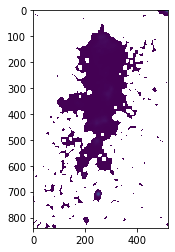

In [20]:
plt.imshow(cont_flux2[0])